# Lung analysis

In [1]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,matplotlib,seaborn,hsbmpy,topicpy -a Filippo_Valle -g -r -b -w

Author: Filippo_Valle

Last updated: Tue Feb 08 2022

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.22.0

pandas    : 1.2.4
numpy     : 1.19.5
matplotlib: 3.4.2
seaborn   : 0.11.1
hsbmpy    : not installed
topicpy   : not installed

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 92731dbe84ae34b2ef487d4bd4db5248c4343735

Git repo: https://github.com/SnigdhaJamwal/BoltBio.git

Git branch: kushan

Watermark: 2.3.0



In [2]:
# import libraries
import pandas as pd
import numpy as np
import sys, gc, os

PATH_TO_UTILS = '/Users/kushan/BoltBio/code/utils/GE'
PATH_TO_PREPROCESS = '/Users/kushan/BoltBio/code/preprocessing'
PATH = os.getcwd()


In [3]:
df_tcgabiolinks = pd.read_csv(f"{PATH_TO_UTILS}/TCGA_biolinks.csv", index_col=0).dropna(how="all", axis=1)
df_tcgabiolinks = df_tcgabiolinks[df_tcgabiolinks["cancer.type"].isin(["LUAD"])].set_index("pan.samplesID")
df_tcgabiolinks.head(2)

,cancer.type,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
pan.samplesID,,,,,,,,,
TCGA-05-4249,LUAD,NaN,NaN,NaN,NaN,NaN,5,NaN,LUAD.5
TCGA-05-4382,LUAD,NaN,NaN,NaN,NaN,NaN,6,NaN,LUAD.6


We read a file *files_tcga.dat* obtained trough **gdc** API

In [4]:
df_files=pd.read_csv(f"{PATH_TO_UTILS}/files_tcga.dat", index_col=0)
df_files=df_files.drop_duplicates("cases.0.submitter_id")
df_files.sort_values('cases.0.submitter_id', inplace=True)

df_files=df_files[df_files['cases.0.submitter_id'].isin(df_tcgabiolinks.index)]

We append and merge the file from TCGA (gdc API) and the one from TCGA-Biolinks ([subtypes](https://bioconductor.org/packages/release/bioc/vignettes/TCGAbiolinks/inst/doc/subtypes.html))

In [5]:
df_files = df_files.reset_index().set_index('cases.0.submitter_id')
df_files = df_files.transpose().append(df_tcgabiolinks.reindex(index=df_files.index).transpose()).transpose()

In [6]:
#df_files.dropna(how="any", axis=1, thresh=len(df_files.index)/25, inplace=True)
df_files.reset_index().set_index("file_name").fillna("unknown").to_csv(f"{PATH_TO_UTILS}/files.dat", index=True)

## Table of RNA-Seq data
We got and prepare the data using [Table_Creation.ipynb](Table_Creation.ipynb) and [TCGA_GetManifest.ipynb](TCGA_GetManifest.ipynb)

*mainfest.txt* files are available in this repository

In [7]:
df_files=df_files.fillna("unknown").set_index("file_name")
df_files.to_csv(f"{PATH_TO_UTILS}/files.dat", index=True, header=True)

In [8]:
df = pd.read_csv(f"{PATH_TO_UTILS}/mainTable_all.csv",index_col=0)

We ensure that all columns have a metadata entry in *df_files*

In [9]:
df = df.reindex(columns=df.columns[df.columns.isin(df_files.index)])
df.to_csv(f"{PATH_TO_UTILS}/mainTable.csv", index=True, header=True)
df_files.fillna("unknown").to_csv(f"{PATH_TO_UTILS}/files.dat", index=True)

We import *scanpy* to select **highly variable genes**

In [10]:
import scanpy as sc
sc.settings.verbosity = 2
df.shape

(60483, 185)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


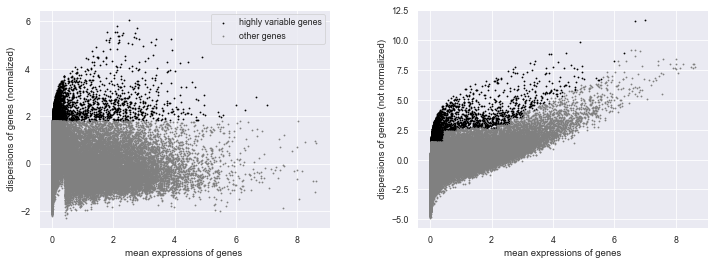

In [11]:
adata = sc.AnnData(X=df.transpose(), obs=df_files.reindex(index=df.columns))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)
hvg = adata.var[adata.var["highly_variable"]==True].index

In [12]:
adata

AnnData object with n_obs × n_vars = 185 × 60483
    obs: 'cases.0.demographic.days_to_birth', 'cases.0.demographic.days_to_death', 'cases.0.demographic.gender', 'cases.0.demographic.vital_status', 'cases.0.diagnoses.0.age_at_diagnosis', 'cases.0.diagnoses.0.days_to_last_follow_up', 'cases.0.diagnoses.0.last_known_disease_status', 'cases.0.exposures.0.cigarettes_per_day', 'cases.0.exposures.0.years_smoked', 'cases.0.project.project_id', 'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id', 'cancer.type', 'Subtype_mRNA', 'Subtype_DNAmeth', 'Subtype_protein', 'Subtype_miRNA', 'Subtype_CNA', 'Subtype_Integrative', 'Subtype_other', 'Subtype_Selected'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [13]:
hvg

Index(['ENSG00000172137', 'ENSG00000234943', 'ENSG00000234881',
       'ENSG00000278099', 'ENSG00000204113', 'ENSG00000189099',
       'ENSG00000273797', 'ENSG00000211950', 'ENSG00000243911',
       'ENSG00000129455',
       ...
       'ENSG00000278439', 'ENSG00000266146', 'ENSG00000207967',
       'ENSG00000221303', 'ENSG00000176358', 'ENSG00000211660',
       'ENSG00000253844', 'ENSG00000221542', 'ENSG00000275704',
       'ENSG00000173930'],
      dtype='object', name='gene', length=3000)

In [14]:
df.reindex(index=hvg).shape

(3000, 185)

In [15]:
# save the table with HVG
df.reindex(index=hvg).to_csv(f"{PATH_TO_UTILS}/mainTable.csv", index=True, header=True)

In [16]:
adata = sc.AnnData(X=df.transpose(), obs=df_files.reindex(index=df.columns))
adata.raw = adata
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:10])

(185, 60483)
(185, 60483)
[[0.0000e+00 0.0000e+00 1.5100e+00 0.0000e+00 3.3400e+00 3.4530e+01
  0.0000e+00 8.0000e-02 2.0034e+02 6.0000e-02]
 [0.0000e+00 1.0000e-02 2.4000e+00 0.0000e+00 4.8100e+00 6.6400e+00
  0.0000e+00 6.4000e-01 1.4196e+02 4.0000e-02]
 [0.0000e+00 0.0000e+00 2.8000e+00 0.0000e+00 7.5900e+00 4.7900e+00
  0.0000e+00 1.6000e-01 3.4489e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 2.4900e+00 0.0000e+00 3.7600e+00 1.3990e+01
  0.0000e+00 6.9000e-01 1.0294e+02 7.0000e-02]
 [0.0000e+00 1.0000e-02 4.0400e+00 0.0000e+00 3.9600e+00 3.3000e+00
  0.0000e+00 2.4000e-01 1.6435e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 4.0500e+00 0.0000e+00 3.9800e+00 1.3300e+01
  0.0000e+00 8.0000e-02 2.2069e+02 5.0000e-02]
 [2.0000e-02 0.0000e+00 3.4900e+00 0.0000e+00 2.6600e+00 1.4510e+01
  0.0000e+00 9.1000e-01 1.8994e+02 1.0000e-01]
 [0.0000e+00 0.0000e+00 3.6400e+00 0.0000e+00 3.9600e+00 1.0920e+01
  4.0000e-02 1.0000e-01 1.8024e+02 9.0000e-02]
 [8.0000e-02 0.0000e+00 9.3000e-01 0.0000e+00 8.4000e+

In [17]:
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [18]:
adata

AnnData object with n_obs × n_vars = 185 × 60483
    obs: 'cases.0.demographic.days_to_birth', 'cases.0.demographic.days_to_death', 'cases.0.demographic.gender', 'cases.0.demographic.vital_status', 'cases.0.diagnoses.0.age_at_diagnosis', 'cases.0.diagnoses.0.days_to_last_follow_up', 'cases.0.diagnoses.0.last_known_disease_status', 'cases.0.exposures.0.cigarettes_per_day', 'cases.0.exposures.0.years_smoked', 'cases.0.project.project_id', 'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id', 'cancer.type', 'Subtype_mRNA', 'Subtype_DNAmeth', 'Subtype_protein', 'Subtype_miRNA', 'Subtype_CNA', 'Subtype_Integrative', 'Subtype_other', 'Subtype_Selected', 'n_counts'
    uns: 'log1p'

In [19]:
for i in adata.obs.keys():
    try:
        adata.obs[i].cat
        print(f'{i} works')
        print(adata.obs[i].cat.categories)
        
    except:
        pass

ranking genes
... storing 'cases.0.demographic.gender' as categorical
... storing 'cases.0.demographic.vital_status' as categorical
... storing 'cases.0.diagnoses.0.last_known_disease_status' as categorical
... storing 'cases.0.project.project_id' as categorical
... storing 'cancer.type' as categorical
... storing 'Subtype_mRNA' as categorical
... storing 'Subtype_DNAmeth' as categorical
... storing 'Subtype_protein' as categorical
... storing 'Subtype_miRNA' as categorical
... storing 'Subtype_CNA' as categorical
... storing 'Subtype_Integrative' as categorical
... storing 'Subtype_other' as categorical
... storing 'Subtype_Selected' as categorical
    finished (0:00:00)


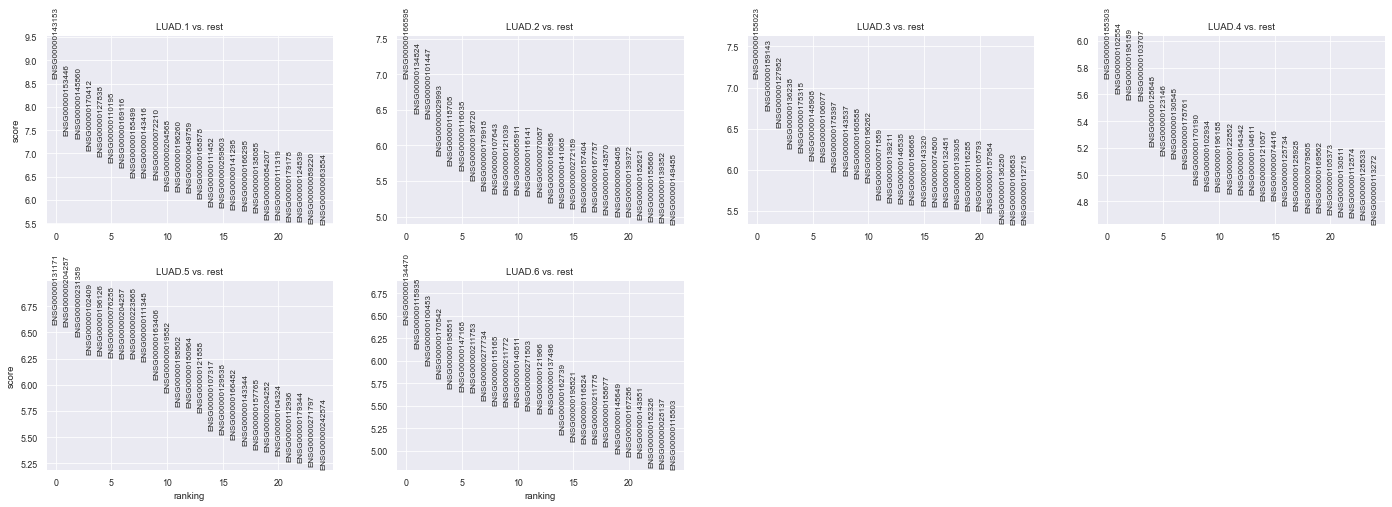

In [20]:
sc.tl.rank_genes_groups(adata, 'Subtype_Selected', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")


ranking genes
    finished (0:00:00)


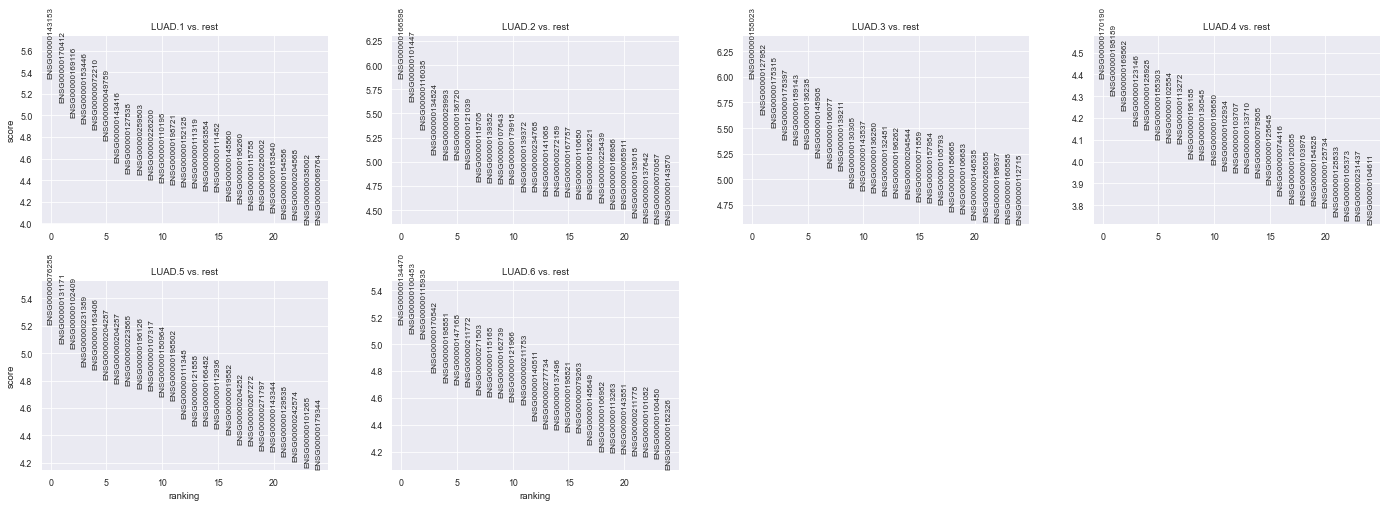

In [21]:
sc.tl.rank_genes_groups(adata, 'Subtype_Selected', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")

ranking genes
    finished (0:00:02)


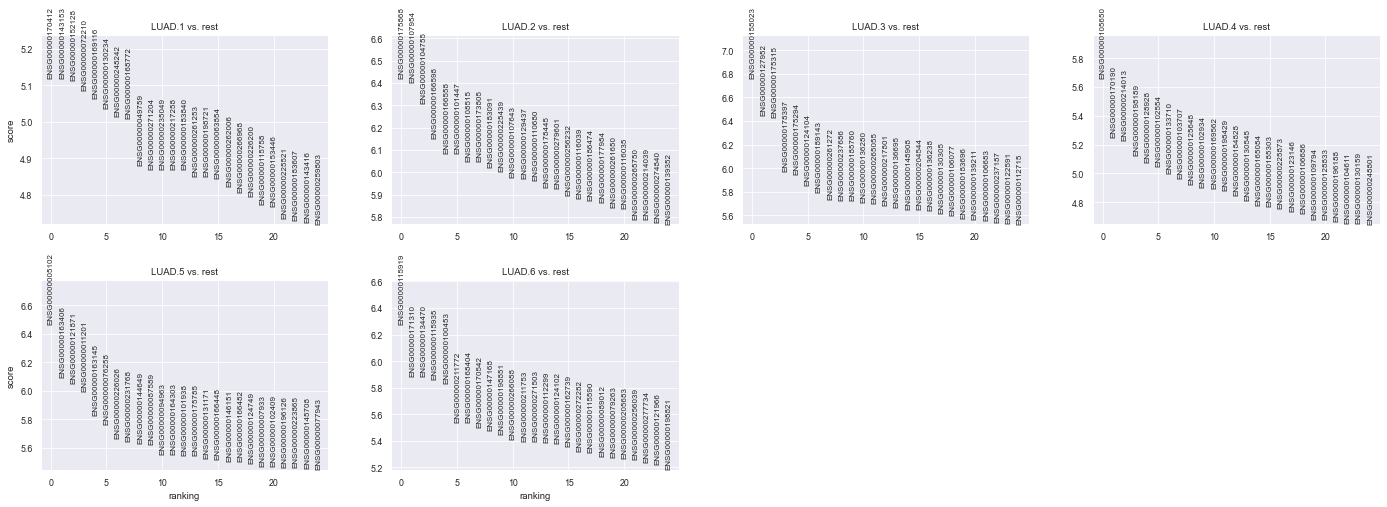

In [22]:
sc.tl.rank_genes_groups(adata, 'Subtype_Selected', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")


ranking genes
/Users/kushan/anaconda3/envs/another/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
    finished (0:00:13)


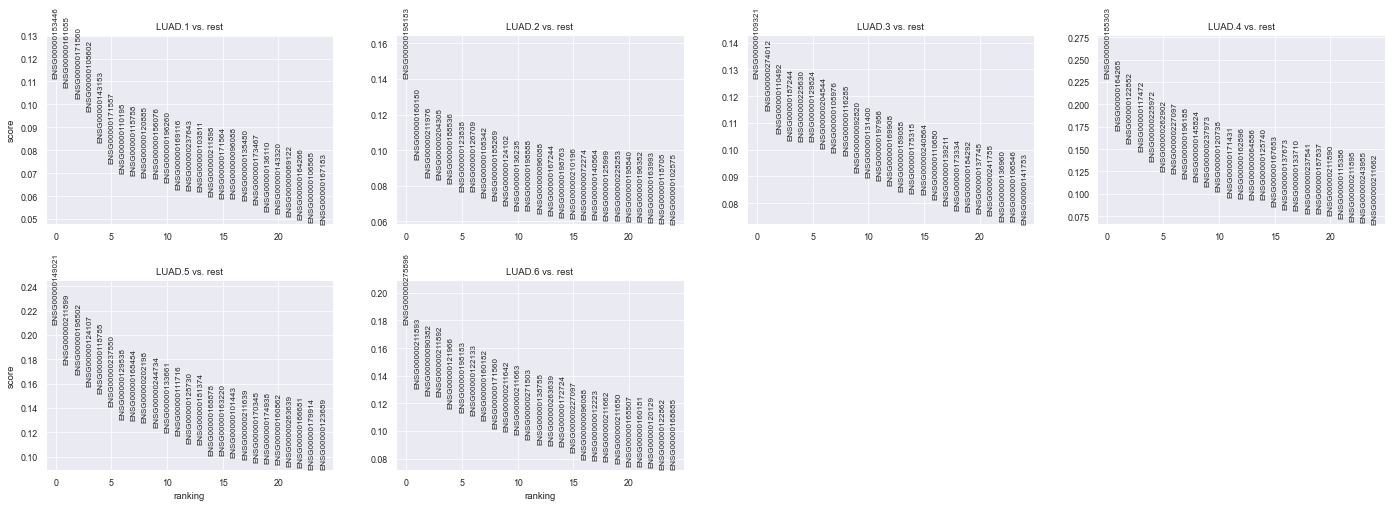

In [23]:
sc.tl.rank_genes_groups(adata, 'Subtype_Selected', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Subtype_Selected']`


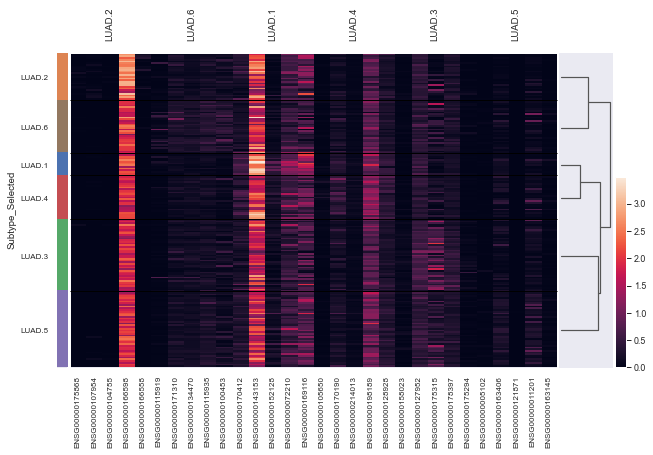

In [24]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="Subtype_Selected", show_gene_labels=True)

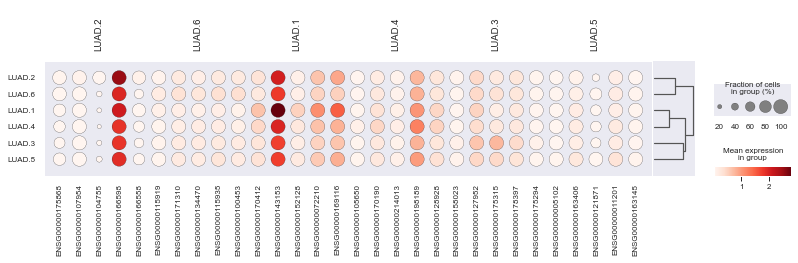

In [25]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="Subtype_Selected")

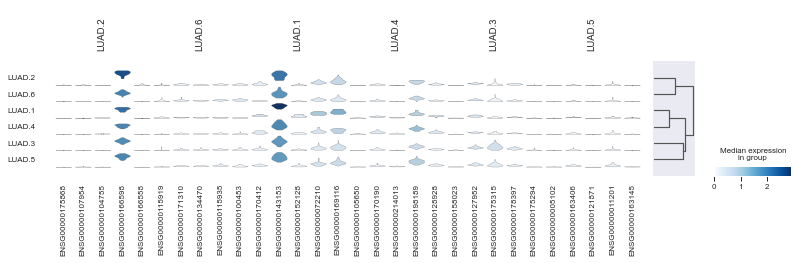

In [26]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby="Subtype_Selected")

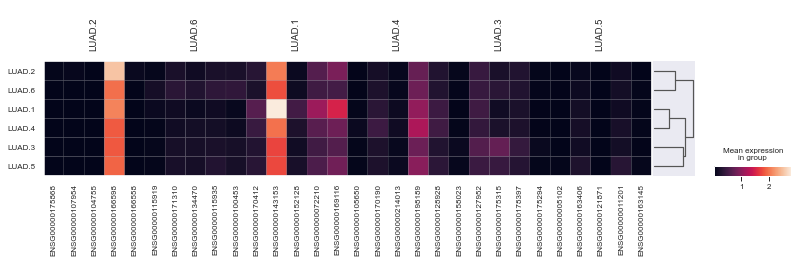

In [27]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="Subtype_Selected")

In [28]:
df = sc.get.rank_genes_groups_df(adata, group = None,
                                    key='wilcoxon', log2fc_min=0.25, 
                                    pval_cutoff=0.01
                                    )
df.set_index('names')
df.to_csv(f'{PATH}/GE_de_genes.csv')
